In [1]:
from nilmtk import *
from nilmtk.disaggregate import fhmm_exact

In [2]:
import time

In [3]:
train = DataSet('/data/REDD/redd.h5')
test = DataSet('/data/REDD/redd.h5')

In [4]:
building = 2
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

In [5]:
train_elec = train.buildings[building].elec
test_elec = test.buildings[building].elec

In [6]:
%matplotlib inline

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was se

/Users/nipunbatra/git/nilmtk/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=1)
  data = data.resample(**resample_kwargs)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


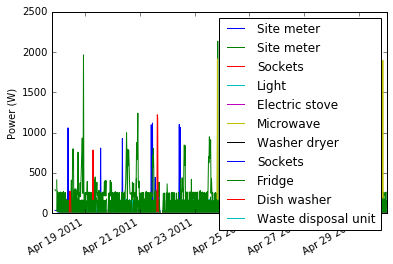

In [7]:
train_elec.plot()

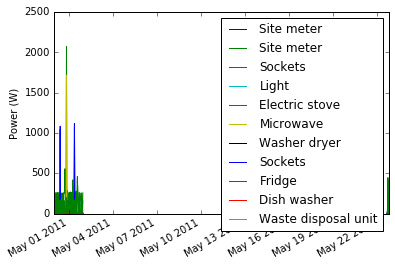

In [8]:
test_elec.plot()

In [10]:
start = time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(train_elec, sample_period=120)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=2, d

In [11]:
import pandas as pd
import numpy as np

In [12]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=120)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=120).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


/Users/nipunbatra/git/nilmtk/nilmtk/utils.py:336: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  return resampled.index[0]


In [13]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [14]:
%matplotlib inline

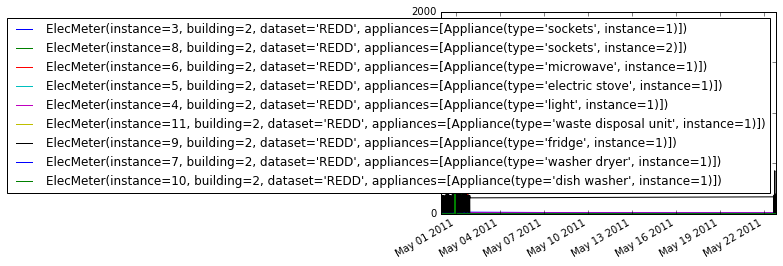

In [15]:
gt_overall.plot()

In [16]:
pred_overall = pred_overall.ix[gt_overall.index]
gt_overall = gt_overall.ix[pred_overall.index]

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
rmse={}
for col in pred_overall.columns:
    rmse[col] = np.sqrt(mean_squared_error(gt_overall[col], pred_overall[col]))

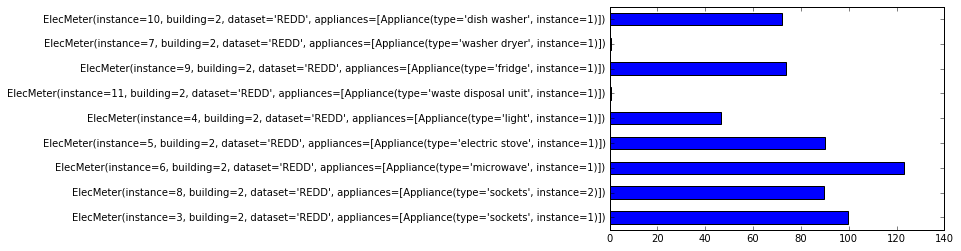

In [20]:
pd.Series(rmse).plot(kind="barh")